In [16]:
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet langchain-community
!pip install  --quiet langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 kB 3.1 MB/s eta 0:00:00


In [46]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
from typing import TypedDict, Annotated, List
import textwrap

from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, END, START
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

In [8]:
google_api_key = userdata.get('GOOGLE_API_KEY')

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                                                      api_key=google_api_key
                                                      )

model.invoke("What is 2+2?").content

'2 + 2 = 4\n'

In [47]:
def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [40]:
memory = MemorySaver()

class AgentState(TypedDict):
  message: str
  reflection: str
  self_improvement: str
  response: List[str]
  number_of_iters: int

In [41]:
def response_generator_node(state: AgentState):
  """LangGraph node that is responsible to generate response for given message"""
  print("🤖 Response Generator Node \n")
  message = state['message']
  prompt = f"""Generate appropriate response for the message {message}"""
  model_response = model.invoke(prompt).content
  response = state.get('response', [])
  response.append(model_response)
  print(f"\n✉️Response Generator Node ... \n\n {model_response[:150]}")
  return {'response': response}


def reflection_node(state: AgentState):
  """LangGraph node that is responsible to generate reflection for given message"""
  print("🤔 Reflection Node \n")
  response = state['response']
  prompt = f"""Generate appropriate reflection for the response {response}"""
  reflection = model.invoke(prompt).content
  print(f"\n✉️Reflection Node ... \n\n {reflection[:150]}")
  return {'reflection': reflection}


def self_improvement_node(state: AgentState):
  """LangGraph node that is responsible to generate self improvement for given message"""
  print("📈 Self Improvement Node \n")
  reflection = state['reflection']
  prompt = f"""Based on these insights {reflection}, update the agent knowledge and behavior.
          Summarize the key point to remember
          """
  self_improvement = model.invoke(prompt).content
  print(f"\n✉️Self Improvement Node ... \n\n {self_improvement[:150]}")
  return {'self_improvement': self_improvement}


def router(state: AgentState):
  """ A utility function that define how many time to iterate on response to improve"""
  response = state["response"]
  number_of_iters = state.get("number_of_iters", 2)
  number_of_responses = len(response)
  if number_of_responses >= number_of_iters:
    return END
  return "Reflection Node"

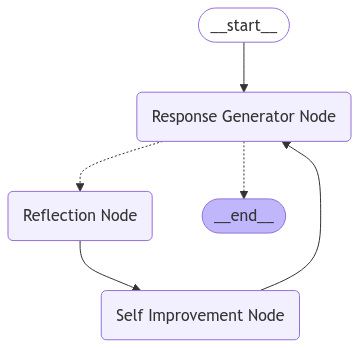

In [42]:
builder: StateGraph = StateGraph(AgentState)

builder.add_node("Response Generator Node", response_generator_node)
builder.add_node("Reflection Node", reflection_node)
builder.add_node("Self Improvement Node", self_improvement_node)

builder.add_edge(START, "Response Generator Node")
builder.add_conditional_edges("Response Generator Node", router, ['Reflection Node', END])
builder.add_edge("Reflection Node", "Self Improvement Node")
builder.add_edge("Self Improvement Node", "Response Generator Node")

agent = builder.compile(checkpointer=memory)
display(Image(agent.get_graph().draw_mermaid_png()))

In [43]:
message = "What is attention in human cognition?"
thread = {"configurable": {"thread_id": "1"}}
response = agent.invoke({"message": message, "num_of_iters": 2}, thread)

🤖 Response Generator Node 


✉️Response Generator Node ... 

 Attention in human cognition refers to the cognitive process of selectively concentrating on a discrete aspect of the environment while ignoring other
🤔 Reflection Node 


✉️Reflection Node ... 

 This response provides a comprehensive and well-structured overview of attention in human cognition.  I appreciate the clear definition that establish
📈 Self Improvement Node 


✉️Self Improvement Node ... 

 The agent's knowledge has been updated to include a more comprehensive understanding of attention in human cognition.  Key improvements include incorp
🤖 Response Generator Node 


✉️Response Generator Node ... 

 Attention in human cognition refers to the cognitive process of selectively concentrating on a discrete aspect of the environment while ignoring other


In [49]:
to_markdown(response['response'][-1])

> Attention in human cognition refers to the cognitive process of selectively concentrating on a discrete aspect of the environment while ignoring other perceivable aspects.  It's not a single, unified process, but rather a complex set of mechanisms that allow us to filter, prioritize, and process information efficiently.  Key aspects include:
> 
> * **Selective attention:** Focusing on one thing while ignoring others (e.g., listening to a conversation in a noisy room).  This involves both focusing on a target stimulus and inhibiting distractions.
> 
> * **Sustained attention:** Maintaining focus over a period of time (e.g., reading a long chapter). This requires vigilance and resistance to fatigue.
> 
> * **Divisive attention:** Attending to multiple things simultaneously (e.g., driving and talking).  This is often limited and can lead to performance decrements in each task.
> 
> * **Switching attention:** Shifting focus between different tasks or stimuli (e.g., alternating between reading and writing). This involves cognitive control and executive functions.
> 
> These different aspects of attention interact and are influenced by various factors such as motivation, arousal, and cognitive load.  Damage to specific brain regions can lead to impairments in different aspects of attention, highlighting the complex neural basis of this crucial cognitive function.  Understanding attention is essential to comprehending how we perceive, learn, and interact with the world.
